<a href="https://colab.research.google.com/github/ykp-cmd/image-processing/blob/main/cv2_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/CycleGAN_Project/pytorch-CycleGAN-and-pix2pix/datasets/capy

/content/drive/My Drive/Colab Notebooks/CycleGAN_Project/pytorch-CycleGAN-and-pix2pix/datasets/capy


input a number 0-3:2


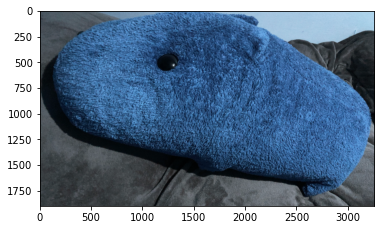

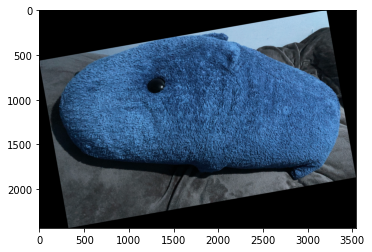

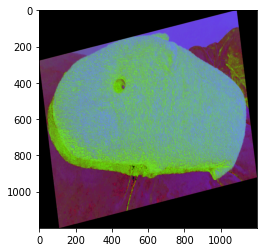

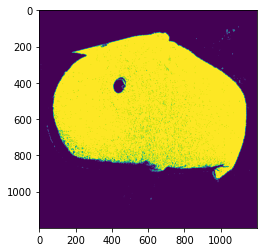

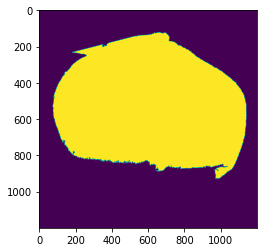

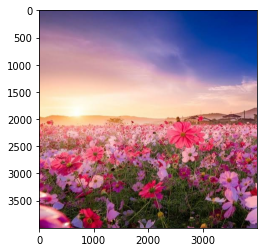

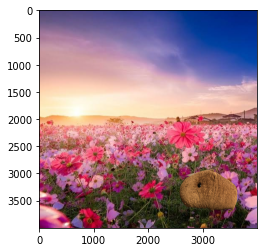

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random

class CapyImSyn:

    def __init__(self, fgImg, bgImg):
        self.fgImg = fgImg
        self.bgImg = bgImg
        self.x = 1500
        self.y = 1500
        self.size = 1000
    
    def setPosition(self, position):
        if (position == 'left'):
            self.x = 500
            self.y = 2800
        elif (position == 'center'):
            self.x = 2000
            self.y = 2000
        elif (position == 'right'):
            self.x = 2500
            self.y = 2800
        elif (position == 'random'):
            self.x = random.choice(range(500, 2500))
            self.y = random.choice(range(500, 2800))

    def setSize(self, size):
        self.size = size
    
    def _createMask(img):
        #convert bgr into hsv
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        plt.imshow(hsv)
        plt.show()

        #binarise
        bin_img = cv2.inRange(hsv, (28, 78, 40), (240, 240, 240))
        plt.imshow(bin_img)
        plt.show()

        #extract contours
        contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #get the contour with the largest area
        contour = max(contours, key=lambda x: cv2.contourArea(x))
        mask = np.zeros_like(bin_img)
        maskImg =  cv2.drawContours(mask, [contour], -1, color=255, thickness=-1)
        plt.imshow(maskImg)
        plt.show()
        return maskImg

    def _imageRotate(img):
        h, w = img.shape[:2]
        size = (w, h)
        
        #set rotation angle
        angle = 10
        angle_rad = angle/180.0*np.pi
        
        #calculate image size after rotation
        w_rot = int(np.round(h*np.absolute(np.sin(angle_rad))+w*np.absolute(np.cos(angle_rad))))
        h_rot = int(np.round(h*np.absolute(np.cos(angle_rad))+w*np.absolute(np.sin(angle_rad))))
        size_rot = (w_rot, h_rot)
        
        #rotate around the centre of the original image
        center = (w/2, h/2)
        scale = 1.0
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
        
        #add a parallel shift(rotation + translation)
        affine_matrix = rotation_matrix.copy()
        affine_matrix[0][2] = affine_matrix[0][2] -w/2 + w_rot/2
        affine_matrix[1][2] = affine_matrix[1][2] -h/2 + h_rot/2

        img = cv2.warpAffine(img, affine_matrix, size_rot, flags=cv2.INTER_CUBIC)
        plt.imshow(img)
        plt.show()
        return img

    def combine(self):
        #randomly select fgImg 
        loadedFgImg = cv2.imread(self.fgImg)
        plt.imshow(loadedFgImg)
        plt.show()
        rot_FgImg = CapyImSyn._imageRotate(loadedFgImg)
        cvt_FgImg = cv2.cvtColor(rot_FgImg, cv2.COLOR_BGR2RGB)
        rs1 = cv2.resize(cvt_FgImg, (self.size, self.size))

        mask = CapyImSyn._createMask(rs1)

        #process in the same way as fgImg
        loadedBgImg = cv2.imread(self.bgImg)
        loadedBgImg_cvt = cv2.cvtColor(loadedBgImg, cv2.COLOR_BGR2RGB)
        rs2 = cv2.resize(loadedBgImg_cvt, (4000, 4000))
        plt.imshow(rs2)
        plt.show()
        
        #set the position for pasting
        x = self.x
        y = self.y

        #width and height take the common part of the foreground and background images
        w = min(rs1.shape[1], rs2.shape[1] - x)
        h = min(rs1.shape[0], rs2.shape[0] - y)

        #area to be merged
        fg_roi = rs1[:h, :w] 
        bg_roi = rs2[y : y + h, x : x + w] 

        #last process 
        bg_roi[:] = np.where(mask[:h, :w, np.newaxis] == 0, bg_roi, fg_roi)
        plt.imshow(rs2)
        plt.show()

fgImgs = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/CycleGAN_Project/pytorch-CycleGAN-and-pix2pix/datasets/capycopied/fgcapy/*.jpg'))
bgImgs = glob.glob('/content/drive/MyDrive/Colab Notebooks/CycleGAN_Project/pytorch-CycleGAN-and-pix2pix/datasets/capycopied/bgcapy/*.jpg')
#randomly select fgImg
fgImg = random.choice(fgImgs)
#interactively select bgImg
flen = len(bgImgs)
n = int(input(f"input a number 0-{flen-1}:"))
if n <= flen:
    #set images and generate instances
    bgImg = bgImgs[n]
    capy = CapyImSyn(fgImg,bgImg)
    capy.setPosition('right')
    capy.setSize(1200)
    capy.combine()
else:
    print("No files exist. Try again.")


